In [1]:
from pathlib import Path
import torch
from torch import nn,optim
from mltools import ld,draw,models

In [2]:
train_iter,val_iter,test_iter=ld.mnist('./data',batch_size=1000) # 获取训练集、验证集和测试集
rnn_layer=nn.LSTM(28, hidden_size=512, batch_first=True, bidirectional=True) # 定义循环网络LSTM
model=models.RNNModel(rnn_layer, vocab_size=28, step_size=28, output_size=10, one_hot=False) # 定义训练模型
device=torch.device('cuda')
model_path='./model/LSTM_MNIST.pth'

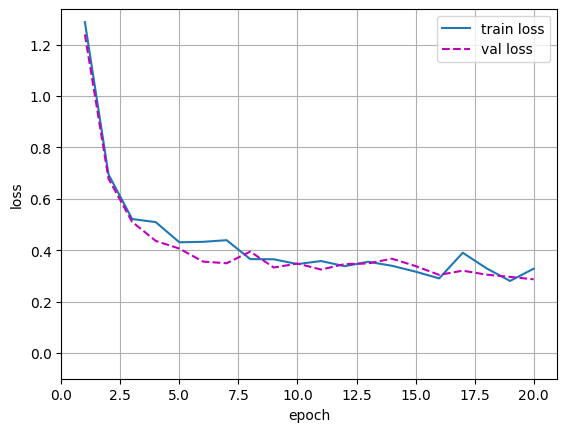

In [3]:
# 训练
def train(model, train_iter, val_iter, *, num_epochs, learning_rate, device):
    model.to(device) # 将网络复制到device上
    loss = nn.CrossEntropyLoss() # 定义损失函数
    optimizer = torch.optim.SGD(model.parameters(), learning_rate) # 定义优化器
    animator=draw.Animator(line_num=2,xlabel='epoch',ylabel='loss',xlim=[0, num_epochs+1],ylim=-0.1,legend=['train loss','val loss'])
    for epoch in range(num_epochs):
        # 计算训练集
        for x, y in train_iter:
            # 运算
            x, y = x.squeeze(1).to(device), y.to(device)
            y_train, _ = model(x)
            train_loss = loss(y_train, y)
            # 梯度更新
            optimizer.zero_grad()
            train_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=2)
            optimizer.step()
        # 计算验证集
        with torch.no_grad():
            for x, y in val_iter:
                # 运算
                x, y = x.squeeze(1).to(device), y.to(device)
                y_val, _ = model(x)
                val_loss = loss(y_val, y)
        animator.add(train_loss.detach().cpu(),val_loss.detach().cpu()) # 添加损失值

if Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    train(model,train_iter,val_iter,num_epochs=20,learning_rate=1e-1,device=device)
    torch.save(model.state_dict(), model_path)

In [4]:
# 测试模型
def test(model,test_iter,device):
    model.to(device) # 将网络复制到device上
    test_num,real_num=0,0 # 定义测试数量和预测真实数量
    # 测试
    for x,y in test_iter:
        x,y=x.squeeze(1).to(device),y.to(device)
        y_test, _ = model(x)
        y_test=y_test.argmax(dim=1)
        pred=y==y_test
        test_num+=len(pred)
        real_num+=pred.sum()
    print(f'Accuracy rate {real_num/test_num}') # 计算测试准确率并输出
test(model,test_iter,device)

Accuracy rate 0.9138000011444092


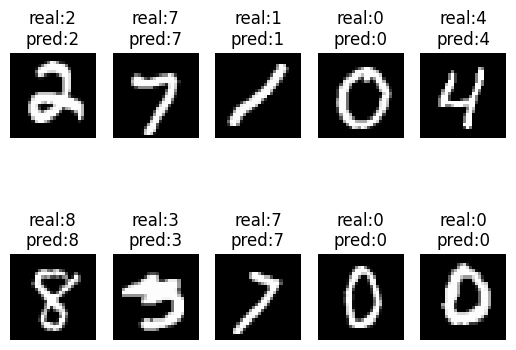

In [5]:
# 预测模型
def predict(model,test_iter,device):
    model.to(device) # 将网络复制到device上
    # 从测试中取一个批量
    x,y=next(iter(test_iter))
    x,y=x[:10].squeeze(1).to(device),y[:10].to(device)
    # 预测
    y_pred, _ = model(x)
    y_pred = y_pred.argmax(dim=1)
    labels=[f'real:{y[index]}\npred:{y_pred[index]}' for index in range(len(y))]
    # 输出样例图
    draw.images(x.unsqueeze(1),labels,shape=(2,5))
predict(model,test_iter,device)